# Facebook Prophet

In this notebook, we investigate using [Facebook prophet](https://facebook.github.io/prophet/) to make forecasts of the price of bitcoin.

Facebook prophet is a timeseries model produced by facebook.
The dataframes need to have only two columns ```['ds','y']``` 


```'ds'``` = ```Date```

```'y'```   = ```Prediction``` 

# Import utils and helper functions

In [1]:
%run utils.ipynb

2.4.1


In [90]:
#Prophet
from fbprophet import Prophet
from matplotlib.pyplot import xlabel,ylabel,title

# Get the stocks data

In [2]:
df = get_stocks_df()

Connecting to the PostgreSQL database...
Connection successful


In [4]:
df.head()

,close,volume
dt,,
2015-10-08 13:40:00+00:00,242.50,0.050000
2015-10-08 13:41:00+00:00,242.95,0.001000
2015-10-08 13:42:00+00:00,242.95,NaN
2015-10-08 13:43:00+00:00,242.96,0.010000
2015-10-08 13:44:00+00:00,242.96,0.033491


## Resample to daily and impute any missing data points

In [50]:
# Since these are close prices, to get the daily close resample with D then get the last
daily_df = df.resample('D').last()

In [51]:
daily_df.head()

,close,volume
dt,,
2015-10-08 00:00:00+00:00,243.95,5.211300
2015-10-09 00:00:00+00:00,245.39,0.000800
2015-10-10 00:00:00+00:00,246.30,4.410000
2015-10-11 00:00:00+00:00,249.50,0.402812
2015-10-12 00:00:00+00:00,247.60,3.400000


In [52]:
# Do we have any missing prices?
daily_df[daily_df['close'].isnull()].head()

,close,volume
dt,,
2018-08-24 00:00:00+00:00,NaN,NaN
2018-11-16 00:00:00+00:00,NaN,NaN
2018-11-17 00:00:00+00:00,NaN,NaN
2018-11-18 00:00:00+00:00,NaN,NaN
2018-11-19 00:00:00+00:00,NaN,NaN


In [53]:
# We have some missing close prices for example 2018-11-16. Let's investigate the original data around that day
df[(df.index > '2018-08-23 01:54') & (df.index < '2018-08-25 16:45')]

,close,volume
dt,,
2018-08-23 01:55:00+00:00,6413.87,3.132555
2018-08-23 01:56:00+00:00,6413.87,NaN
2018-08-23 01:57:00+00:00,6413.87,NaN
2018-08-23 01:58:00+00:00,6413.92,0.426060
2018-08-25 16:44:00+00:00,6709.99,0.046878


In [54]:
# So we have some missing values and can't get daily prices from dates like 2018-08-24. We could impute the values with ffill
daily_df.fillna(method='ffill').isnull().sum()

close     0
volume    0
dtype: int64

In [55]:
daily_df = daily_df.fillna(method='ffill')

In [59]:
daily_df[(daily_df.index > '2018-08-21') & (daily_df.index < '2018-08-27')]

,close,volume
dt,,
2018-08-22 00:00:00+00:00,6350.00,1.042065
2018-08-23 00:00:00+00:00,6413.92,0.426060
2018-08-24 00:00:00+00:00,6413.92,0.426060
2018-08-25 00:00:00+00:00,6730.95,0.041640
2018-08-26 00:00:00+00:00,6675.73,4.000000


## Imports & API

### Imports

In [3]:
import json

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
#because of the built in plotting objects in Prophet, it is easier to import/use these externally from plt.

#scrap / API
import requests 



## Instantiate the model

In [69]:
model = Prophet(
    #daily_seasonality=True)
)

In [64]:
# Get the dataframe in the format that prophet likes with cols ds and y
daily_df_p = daily_df.close.reset_index().rename(columns={'dt': 'ds', 'close': 'y'})

In [83]:
daily_df_p.tail()

,ds,y
1957,2021-02-15,47927.17
1958,2021-02-16,49137.93
1959,2021-02-17,52162.57
1960,2021-02-18,51601.10
1961,2021-02-19,53714.41


In [67]:
daily_df_p.dtypes

ds    datetime64[ns, UTC]
y                 float64
dtype: object

In [75]:
# Need to remove the timezone
daily_df_p['ds'] = daily_df_p['ds'].dt.tz_convert(None)

In [76]:
model.fit(daily_df_p)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [84]:
future = model.make_future_dataframe(periods=14, include_history=False)
future

,ds
0,2021-02-20
1,2021-02-21
2,2021-02-22
3,2021-02-23
4,2021-02-24
5,2021-02-25
6,2021-02-26
7,2021-02-27
8,2021-02-28
9,2021-03-01


In [78]:
predictions = model.predict(future)
predictions.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-02-20,26921.609659,27443.713021,34025.053304,26921.609659,26921.609659,3808.229506,3808.229506,3808.229506,-12.061235,-12.061235,-12.061235,3820.290741,3820.290741,3820.290741,0.0,0.0,0.0,30729.839165
1,2021-02-21,26982.911315,27309.900270,34250.722545,26982.911315,26982.911315,3615.397667,3615.397667,3615.397667,-44.662452,-44.662452,-44.662452,3660.060119,3660.060119,3660.060119,0.0,0.0,0.0,30598.308982
2,2021-02-22,27044.212971,27065.216827,33695.670245,27044.212971,27044.212971,3473.206880,3473.206880,3473.206880,-8.822295,-8.822295,-8.822295,3482.029175,3482.029175,3482.029175,0.0,0.0,0.0,30517.419851
3,2021-02-23,27105.514627,27149.455209,33729.531307,27105.514627,27105.514627,3271.209103,3271.209103,3271.209103,-17.166485,-17.166485,-17.166485,3288.375589,3288.375589,3288.375589,0.0,0.0,0.0,30376.723731
4,2021-02-24,27166.816283,26881.621604,33536.417101,27166.816283,27166.816283,3097.468658,3097.468658,3097.468658,15.915692,15.915692,15.915692,3081.552966,3081.552966,3081.552966,0.0,0.0,0.0,30264.284941


In [79]:
simple_predictions = predictions[['ds','yhat']]
simple_predictions.head()

,ds,yhat
0,2021-02-20,30729.839165
1,2021-02-21,30598.308982
2,2021-02-22,30517.419851
3,2021-02-23,30376.723731
4,2021-02-24,30264.284941


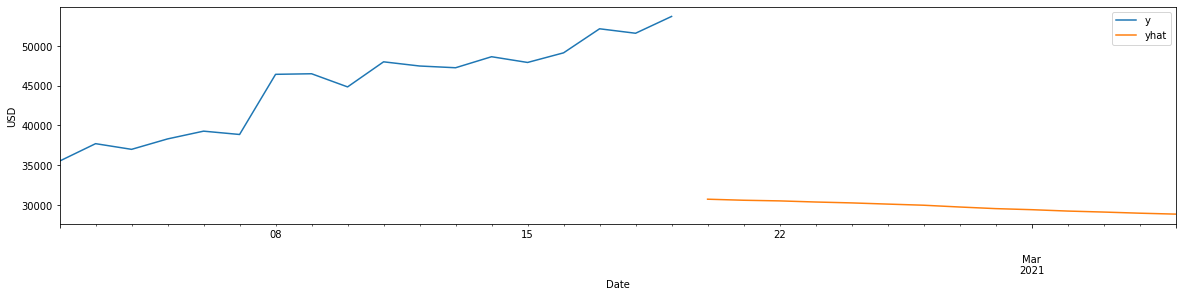

In [98]:
# Plot of the original data from recent history
ax = daily_df_p[daily_df_p.ds > '2021-02-01'].set_index('ds').plot(figsize=(20,4))

# Plot of the forecasted values on the same axis
simple_predictions.set_index('ds').plot(figsize=(20,4), ax=ax)
xlabel('Date')
ylabel('USD');

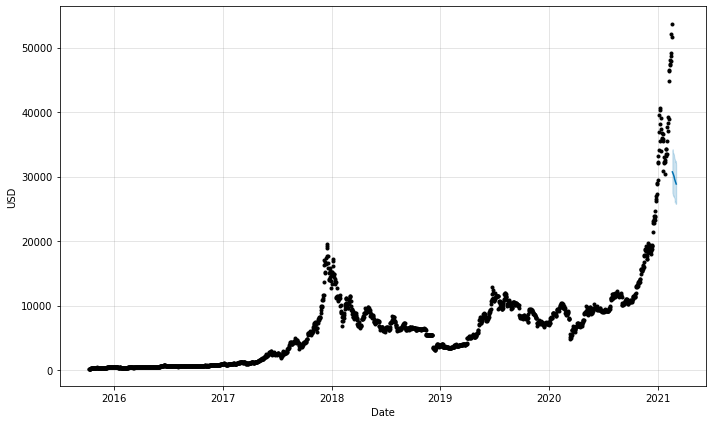

In [91]:
model.plot(predictions)
xlabel('Date')
ylabel('USD');

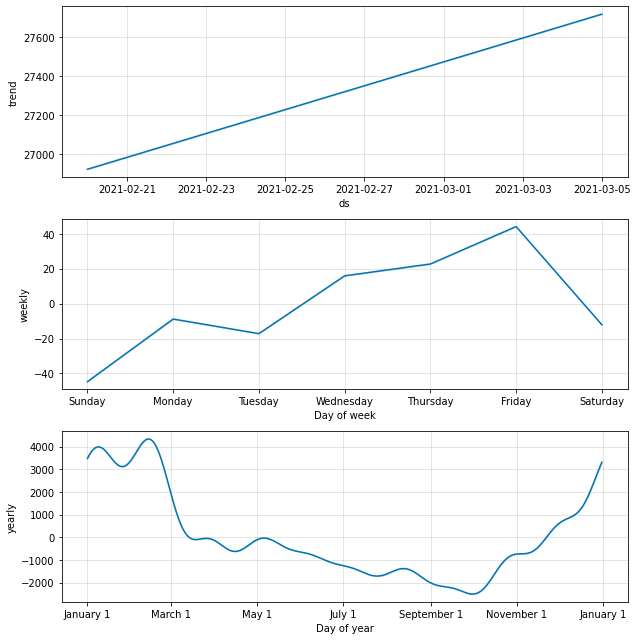

In [95]:
model.plot_components(predictions);

## Use only recent history

The above forecast was not too impressive

In [101]:
model = Prophet(#daily_seasonality=True)
)

In [102]:
rec_daily_df = daily_df_p[daily_df_p.ds > '2021-02-01']

In [103]:
model.fit(rec_daily_df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


In [104]:
future = model.make_future_dataframe(periods=14, include_history=False)
future.head()

,ds
0,2021-02-20
1,2021-02-21
2,2021-02-22
3,2021-02-23
4,2021-02-24


In [105]:
predictions = model.predict(future)
predictions.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-02-20,53876.498175,51356.079429,54649.600488,53863.476656,53888.099295,-822.087857,-822.087857,-822.087857,-822.087857,-822.087857,-822.087857,0.0,0.0,0.0,53054.410318
1,2021-02-21,54754.588241,51647.129690,55064.676971,54702.494774,54802.172898,-1400.501452,-1400.501452,-1400.501452,-1400.501452,-1400.501452,-1400.501452,0.0,0.0,0.0,53354.086789
2,2021-02-22,55632.678307,54945.311569,58307.176744,55522.914892,55727.656412,958.760984,958.760984,958.760984,958.760984,958.760984,958.760984,0.0,0.0,0.0,56591.439291
3,2021-02-23,56510.768373,55349.067837,58643.393866,56341.408170,56672.354786,375.340849,375.340849,375.340849,375.340849,375.340849,375.340849,0.0,0.0,0.0,56886.109222
4,2021-02-24,57388.858439,56319.101649,59475.445087,57150.406378,57636.492445,559.140898,559.140898,559.140898,559.140898,559.140898,559.140898,0.0,0.0,0.0,57947.999337


In [108]:
simple_predictions = predictions[['ds','yhat']]
simple_predictions.head()

,ds,yhat
0,2021-02-20,53054.410318
1,2021-02-21,53354.086789
2,2021-02-22,56591.439291
3,2021-02-23,56886.109222
4,2021-02-24,57947.999337


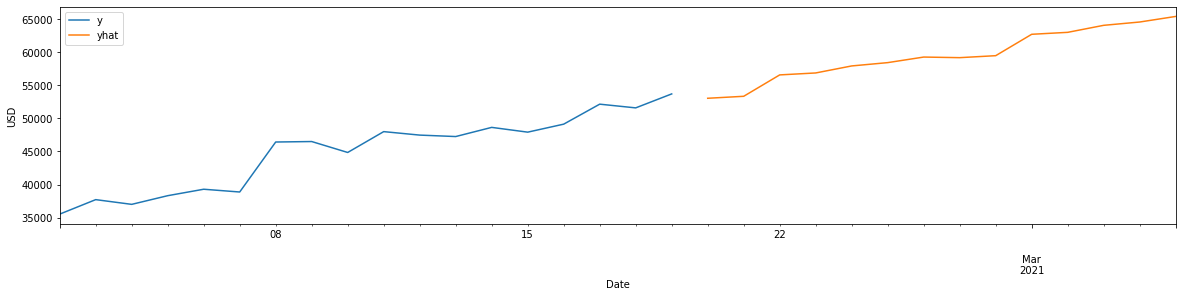

In [110]:
# Plot of the original data
ax = rec_daily_df.set_index('ds').plot(figsize=(20,4))

# Plot of the forecasted values
simple_predictions.set_index('ds').plot(figsize=(20,4), ax=ax)
xlabel('Date')
ylabel('USD');

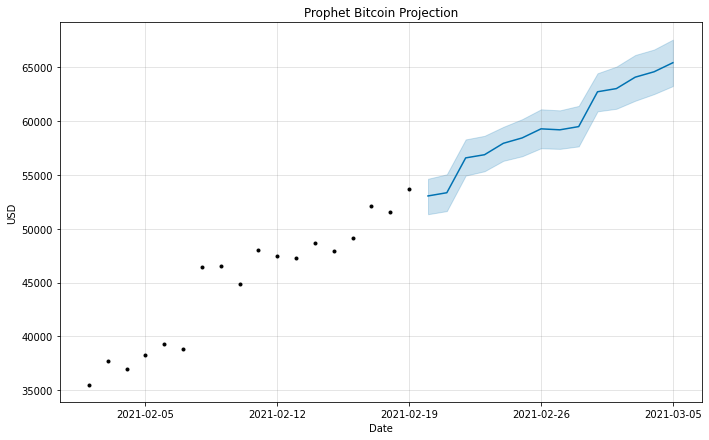

In [111]:
model.plot(predictions)
xlabel('Date')
ylabel('USD')
title('Prophet Bitcoin Projection');

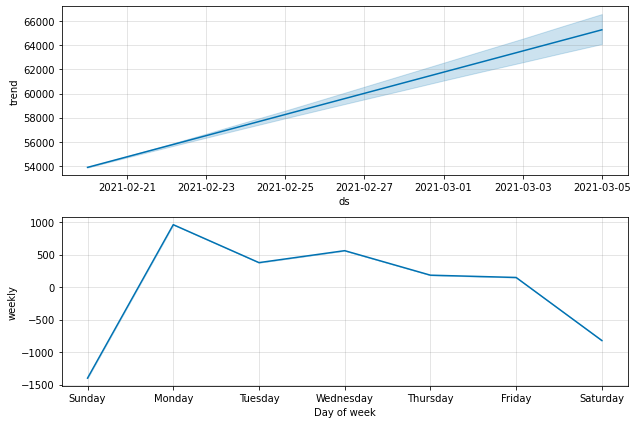

In [112]:
model.plot_components(predictions);